In [0]:
%pip install tensorflow
%pip install tabulate

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


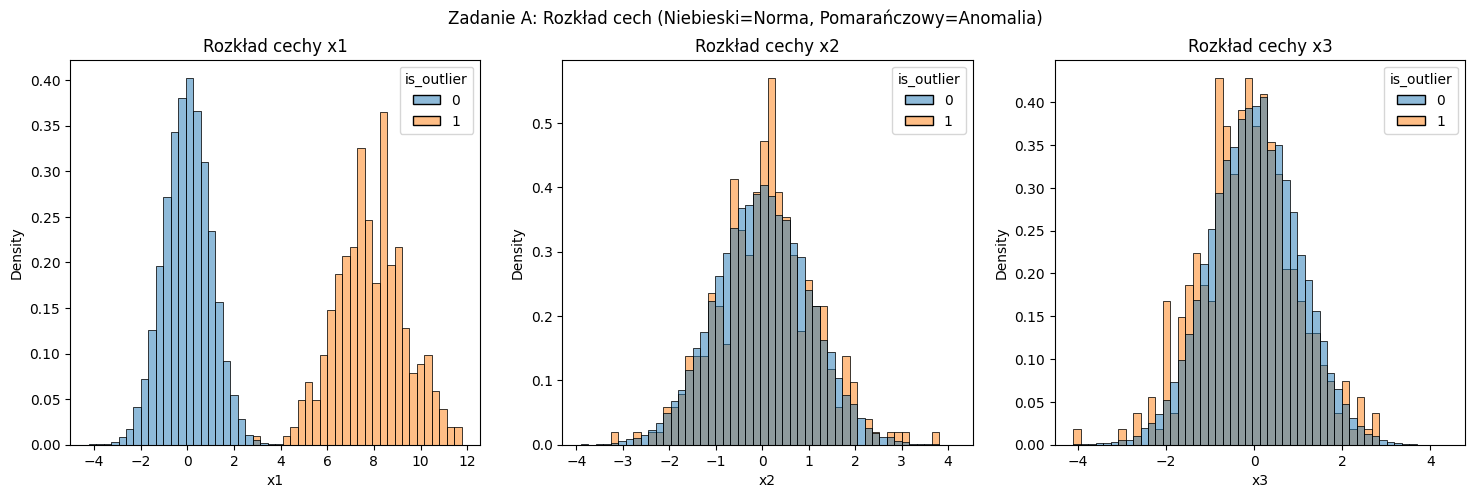

Trenowanie modelu Zmodyfikowanego (V2)...
Próg 1 (Wadliwy): 39.7808837890625
Próg 2 (Precyzyjny 99%): 4.939696788787842
Próg 3 (Wizualny): 5.0

--- ZADANIE C: Porównanie skuteczności metod progowania ---
| Metoda                    |    Próg |   TP |   FP |   FN |   Precision |   Recall |   F1-Score |
|:--------------------------|--------:|-----:|-----:|-----:|------------:|---------:|-----------:|
| 1. Oryginalna (approx 1%) | 39.7809 |    1 |    0 | 2999 |      1      |   0.0003 |     0.0007 |
| 2. Precyzyjna (99%)       |  4.9397 | 2952 |   50 |   48 |      0.9833 |   0.984  |     0.9837 |
| 3. Ekspercka (Fixed=5.0)  |  5      | 2947 |   43 |   53 |      0.9856 |   0.9823 |     0.984  |

Macierz pomyłek dla Metody 3 (Ekspercka):
+----------+----------+------+
|is_outlier|is_anomaly| count|
+----------+----------+------+
|         0|         0|296957|
|         0|         1|    43|
|         1|         0|    53|
|         1|         1|  2947|
+----------+----------+------+



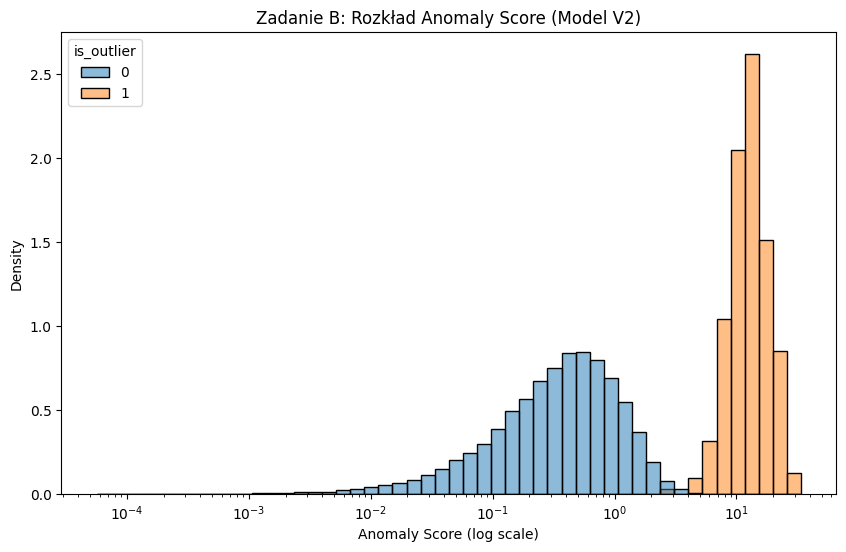

--- CZĘŚĆ 1: SKALOWANIE DANYCH ---

>>> [TEST WOLUMENU] N=300000 WIERSZY...
   Czas ETL: 0.60 s
   Czas Skoringu: 6.93 s

>>> [TEST WOLUMENU] N=600000 WIERSZY...
   Czas ETL: 0.58 s
   Czas Skoringu: 12.41 s

--- CZĘŚĆ 2: WPŁYW FRAGMENTACJI (Symulacja Batcha) ---
   Liczba partycji = 200: 25.44 s
   Liczba partycji = 2: 9.98 s

=== WYNIKI KOŃCOWE D ===
Skalowanie Danych (300k->600k): Czas x1.79
Test Overheadu (200 partycji vs 2 partycje): 25.44s vs 9.98s
Wniosek: Zbyt duża fragmentacja (małe porcje) spowolniła proces 2.55-krotnie.


In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, LongType, DoubleType, IntegerType

# Inicjalizacja Sparka
spark = SparkSession.builder.getOrCreate()

# ==========================================
# 1. Generowanie danych (Zadanie A - ZMODYFIKOWANE)
# ==========================================
# Zmiana 1: Zmniejszenie udziału anomalii do 1% [cite: 332]
n_total = 300_000
frac_outliers = 0.01 
n_out = int(n_total * frac_outliers)
n_norm = n_total - n_out

# Dane normalne ~ N(0,1) - bez zmian
df_norm = (spark.range(n_norm).select(F.col("id").alias("row_id"))
           .withColumn("x1", F.randn(1))
           .withColumn("x2", F.randn(2))
           .withColumn("x3", F.randn(3))
           .withColumn("is_outlier", F.lit(0)))

# Outliery - Zmiana 2: Anomalie subtelne (tylko na x1) [cite: 333-334]
# x1: Zaburzone (N(8, 1.5))
# x2, x3: Normalne (N(0, 1)) - wyglądają jak zwykłe dane!
df_out = (spark.range(n_out).select((F.col("id") + n_norm).alias("row_id"))
          .withColumn("x1", 8.0 + 1.5 * F.randn(11))   # <-- Zaburzenie
          .withColumn("x2", F.randn(12))               # <-- Brak zaburzenia (udaje normę)
          .withColumn("x3", F.randn(13))               # <-- Brak zaburzenia (udaje normę)
          .withColumn("is_outlier", F.lit(1)))

# Połączenie
df = df_norm.unionByName(df_out).orderBy(F.rand(seed=42))

# --- DODATEK: Kod do wygenerowania wykresów do raportu ---
# Pobieramy próbkę do wizualizacji rozkładów (niezbędne do raportu)
viz_sample = df.sample(False, 0.1).toPandas()

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Zadanie A: Rozkład cech (Niebieski=Norma, Pomarańczowy=Anomalia)')

# Rysujemy histogramy dla x1, x2, x3
for i, col in enumerate(['x1', 'x2', 'x3']):
    sns.histplot(data=viz_sample, x=col, hue='is_outlier', bins=50, ax=axes[i], stat='density', common_norm=False)
    axes[i].set_title(f'Rozkład cechy {col}')

plt.show()

# ==========================================
# 2. Kontrakt cech (RĘCZNA STANDARYZACJA)
# ==========================================
# Omijamy pyspark.ml.StandardScaler, który wywala błędy na Serverless.
# Liczymy statystyki globalne:
stats = df.select(
    F.mean("x1").alias("m1"), F.stddev("x1").alias("s1"),
    F.mean("x2").alias("m2"), F.stddev("x2").alias("s2"),
    F.mean("x3").alias("m3"), F.stddev("x3").alias("s3")
).collect()[0]

# Wyciągamy wartości do zmiennych
m1, s1 = stats["m1"], stats["s1"]
m2, s2 = stats["m2"], stats["s2"]
m3, s3 = stats["m3"], stats["s3"]

# Aplikujemy wzór: (x - mean) / std
df_scaled = df.withColumn("x1_s", (F.col("x1") - m1) / s1) \
              .withColumn("x2_s", (F.col("x2") - m2) / s2) \
              .withColumn("x3_s", (F.col("x3") - m3) / s3) \
              .select("row_id", "x1_s", "x2_s", "x3_s", "is_outlier")

# ==========================================
# 3. Autoenkoder: MODYFIKACJA ARCHITEKTURY (Zadanie B)
# ==========================================
import numpy as np
import tensorflow as tf
from pyspark.sql.types import StructType, StructField, LongType, DoubleType, IntegerType

# Pobranie próbki treningowej (dane z Zadania A)
train_pd = (df_scaled
            .filter(F.col("is_outlier") == 0)
            .sample(withReplacement=False, fraction=0.10, seed=42)
            .select("x1_s", "x2_s", "x3_s")
            .toPandas())

X_train = train_pd[["x1_s", "x2_s", "x3_s"]].values.astype(np.float32)
input_dim = X_train.shape[1]

# --- NOWA ARCHITEKTURA V2 (Bottleneck=1, Dropout) ---
def build_autoencoder_v2(input_dim):
    inputs = tf.keras.Input(shape=(input_dim,))
    
    # Zwiększamy pierwszą warstwę (8 -> 16)
    x = tf.keras.layers.Dense(16, activation="relu")(inputs)
    
    # Dodajemy Dropout (0.1) - regularyzacja
    x = tf.keras.layers.Dropout(0.1)(x)
    
    # Zmniejszamy bottleneck (2 -> 1) - ekstremalna kompresja
    z = tf.keras.layers.Dense(1, activation="relu")(x)
    
    # Symetryczny dekoder
    x = tf.keras.layers.Dense(16, activation="relu")(z)
    outputs = tf.keras.layers.Dense(input_dim)(x)
    
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mse")
    return model

print("Trenowanie modelu Zmodyfikowanego (V2)...")
autoencoder = build_autoencoder_v2(input_dim)
autoencoder.fit(X_train, X_train, epochs=10, batch_size=256, verbose=0)

# Wagi do zmiennej globalnej (Closure)
GLOBAL_MODEL_WEIGHTS = autoencoder.get_weights()

# ==========================================
# 4. Skoring w Spark (Zadanie B)
# ==========================================

# --- TUTAJ BYŁ BRAKUJĄCY SCHEMAT ---
schema = StructType([
    StructField("row_id", LongType(), False),
    StructField("anomaly_score", DoubleType(), False),
    StructField("is_outlier", IntegerType(), False),
])

def score_with_autoencoder(pdf_iter):
    import numpy as np
    import tensorflow as tf
    
    # Budujemy model V2 na workerze
    local_model = build_autoencoder_v2(input_dim=3)
    local_model.set_weights(GLOBAL_MODEL_WEIGHTS)
    
    for pdf in pdf_iter:
        X = pdf[["x1_s", "x2_s", "x3_s"]].values.astype(np.float32)
        recon = local_model.predict(X, verbose=0)
        err = np.mean((X - recon) ** 2, axis=1)
        
        yield pd.DataFrame({
            "row_id": pdf["row_id"].values.astype(np.int64),
            "anomaly_score": err.astype(np.float64),
            "is_outlier": pdf["is_outlier"].values.astype(np.int32),
        })

# Uruchomienie skoringu
scored = df_scaled.mapInPandas(score_with_autoencoder, schema=schema)

# ==========================================
# 5. Zadanie C: Porównanie Metod Wyznaczania Progu
# ==========================================
# scored.cache() # Wyłączone dla Serverless

# --- Definicja 3 różnych progów do porównania ---

# METODA 1: Oryginalna (Wadliwa) - z instrukcji PDF
# Błąd epsilon=0.01 przy progu 0.995 oznacza, że Spark może wziąć max() zamiast kwantyla.
thresh_1 = scored.approxQuantile("anomaly_score", [0.995], 0.01)[0]

# METODA 2: Precyzyjny Percentyl (Naprawiona)
# Celujemy w 99% (bo mamy 1% anomalii). Dajemy bardzo mały epsilon (0.00001).
thresh_2 = scored.approxQuantile("anomaly_score", [0.99], 0.00001)[0]

# METODA 3: Wizualna / Ekspercka (z Wykresu B1)
# Na Twoim wykresie widać, że norma kończy się na <1, a anomalie zaczynają od >8.
# Ustawiamy próg bezpiecznie pośrodku.
thresh_3 = 5.0 

print(f"Próg 1 (Wadliwy): {thresh_1}")
print(f"Próg 2 (Precyzyjny 99%): {thresh_2}")
print(f"Próg 3 (Wizualny): {thresh_3}")

# --- Funkcja pomocnicza do liczenia metryk ---
def calculate_metrics(df, threshold_val, method_name):
    # Oznaczamy anomalie wg danego progu
    temp_df = df.withColumn("is_anomaly", (F.col("anomaly_score") >= F.lit(threshold_val)).cast("int"))
    
    # Liczymy TP, FP, FN
    tp = temp_df.filter("is_outlier=1 AND is_anomaly=1").count()
    fp = temp_df.filter("is_outlier=0 AND is_anomaly=1").count()
    fn = temp_df.filter("is_outlier=1 AND is_anomaly=0").count()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    
    return {
        "Metoda": method_name,
        "Próg": f"{threshold_val:.4f}",
        "TP": tp, "FP": fp, "FN": fn,
        "Precision": f"{precision:.4f}",
        "Recall": f"{recall:.4f}",
        "F1-Score": f"{f1:.4f}"
    }

# --- Obliczenia i Wyświetlenie Tabeli ---
results = []
results.append(calculate_metrics(scored, thresh_1, "1. Oryginalna (approx 1%)"))
results.append(calculate_metrics(scored, thresh_2, "2. Precyzyjna (99%)"))
results.append(calculate_metrics(scored, thresh_3, "3. Ekspercka (Fixed=5.0)"))

# Wyświetlamy wyniki jako Pandas DataFrame dla czytelności
results_pdf = pd.DataFrame(results)
print("\n--- ZADANIE C: Porównanie skuteczności metod progowania ---")
print(results_pdf.to_markdown(index=False))

# Dodatkowo wyświetlamy macierz pomyłek dla najlepszej metody (nr 3)
print("\nMacierz pomyłek dla Metody 3 (Ekspercka):")
scored.withColumn("is_anomaly", (F.col("anomaly_score") >= F.lit(thresh_3)).cast("int")) \
      .groupBy("is_outlier", "is_anomaly").count().orderBy("is_outlier", "is_anomaly").show()

# ==========================================
# DODATEK DO RAPORTU B: Wizualizacja błędu rekonstrukcji
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns

# Pobieramy próbkę wyników do wizualizacji (10% powinno wystarczyć)
scored_viz = scored.sample(False, 0.1, seed=42).toPandas()

plt.figure(figsize=(10, 6))
plt.title("Zadanie B: Rozkład Anomaly Score (Model V2)")

# Używamy skali logarytmicznej na osi X, bo błędy anomalii mogą być bardzo duże
sns.histplot(data=scored_viz, x="anomaly_score", hue="is_outlier", 
             bins=50, stat="density", common_norm=False, log_scale=True)

plt.xlabel("Anomaly Score (log scale)")
plt.show()

# ==========================================
# 6. Zadanie D: Test Skalowalności i Fragmentacji (Overhead)
# ==========================================
import time

# --- A. Test Wolumenu Danych (300k vs 600k) ---
def run_volume_benchmark(n_rows):
    print(f"\n>>> [TEST WOLUMENU] N={n_rows} WIERSZY...")
    
    start_prep = time.time()
    
    # Generowanie
    frac_outliers = 0.01 
    n_out = int(n_rows * frac_outliers)
    n_norm = n_rows - n_out

    df_norm = (spark.range(n_norm).select(F.col("id").alias("row_id"))
               .withColumn("x1", F.randn(1))
               .withColumn("x2", F.randn(2))
               .withColumn("x3", F.randn(3))
               .withColumn("is_outlier", F.lit(0)))

    df_out = (spark.range(n_out).select((F.col("id") + n_norm).alias("row_id"))
              .withColumn("x1", 8.0 + 1.5 * F.randn(11))
              .withColumn("x2", F.randn(12))
              .withColumn("x3", F.randn(13))
              .withColumn("is_outlier", F.lit(1)))

    # Ustawiamy stałą liczbę partycji dla testu wolumenu (np. 8), żeby porównanie było uczciwe
    df_bench = df_norm.unionByName(df_out).repartition(8)

    # Standaryzacja
    df_scaled_bench = df_bench.withColumn("x1_s", (F.col("x1") - m1) / s1) \
                              .withColumn("x2_s", (F.col("x2") - m2) / s2) \
                              .withColumn("x3_s", (F.col("x3") - m3) / s3) \
                              .select("row_id", "x1_s", "x2_s", "x3_s", "is_outlier")
    
    _ = df_scaled_bench.count()
    prep_time = time.time() - start_prep
    print(f"   Czas ETL: {prep_time:.2f} s")
    
    start_score = time.time()
    scored_bench = df_scaled_bench.mapInPandas(score_with_autoencoder, schema=schema)
    _ = scored_bench.filter(F.col("anomaly_score") > 5.0).count()
    score_time = time.time() - start_score
    print(f"   Czas Skoringu: {score_time:.2f} s")
    
    return df_scaled_bench, prep_time, score_time

print("--- CZĘŚĆ 1: SKALOWANIE DANYCH ---")
# Generujemy 300k, żeby mieć zmienną df_300k do drugiej części testu
df_300k, t_prep_300k, t_score_300k = run_volume_benchmark(300_000)
_, t_prep_600k, t_score_600k = run_volume_benchmark(600_000)


# --- B. Test Overheadu (Zadanie D1 - punkt 3 "wpływ batcha/partycji") ---
# Skoro config batcha jest zablokowany, testujemy wpływ liczby zadań (repartition).
# Dużo partycji = małe porcje danych = duży narzut (symulacja małego batcha).
print("\n--- CZĘŚĆ 2: WPŁYW FRAGMENTACJI (Symulacja Batcha) ---")

def measure_overhead_impact(df, num_partitions):
    # Wymuszamy podział danych na zadaną liczbę kawałków
    # Więcej partycji -> mniejsze porcje danych trafiające do Pandas -> większy narzut
    df_part = df.repartition(num_partitions)
    
    start = time.time()
    scored = df_part.mapInPandas(score_with_autoencoder, schema=schema)
    _ = scored.filter(F.col("anomaly_score") > 5.0).count()
    duration = time.time() - start
    
    print(f"   Liczba partycji = {num_partitions}: {duration:.2f} s")
    return duration

# 1. Duży narzut (200 małych zadań - odpowiednik małego batcha)
t_high_overhead = measure_overhead_impact(df_300k, 200) 

# 2. Mały narzut (2 duże zadania - odpowiednik dużego batcha)
t_low_overhead = measure_overhead_impact(df_300k, 2)

print("\n=== WYNIKI KOŃCOWE D ===")
print(f"Skalowanie Danych (300k->600k): Czas x{t_score_600k/t_score_300k:.2f}")
print(f"Test Overheadu (200 partycji vs 2 partycje): {t_high_overhead:.2f}s vs {t_low_overhead:.2f}s")
if t_high_overhead > t_low_overhead:
    print(f"Wniosek: Zbyt duża fragmentacja (małe porcje) spowolniła proces {t_high_overhead / t_low_overhead:.2f}-krotnie.")